In [1]:
import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import pyDOE
import cantera as ct
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.getcwd()+'/../../../../'

import matplotlib.pyplot as plt
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
##########################################################################################
### Input Data

### HYDROGEN
OutputDir          = WORKSPACE_PATH + '/ROMNet/Data/0DReact_Isobaric_10Cases_H2_Sources/'
FigDir             = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet/')

Fuel0              = 'H2:1.0'         
Oxydizer0          = 'O2:1.0, N2:4.0'
t0                 = 1.e-7
tEnd               = 1.e-2

# ### METHANE
# OutputDir          = WORKSPACE_PATH + '/ROMNet/Data/0DReact_Isobaric_500Cases_CH4/'
# Fuel0              = 'CH4:1.0'
# Oxydizer0          = 'O2:0.21, N2:0.79'
# t0                 = 1.e-7
# tEnd               = 0.

MixtureFile        = 'gri30.yaml'
P0                 = ct.one_atm
KeepVec            = ['H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2']

NtInt              = 5000
# Integration        = 'Canteras'
# delta_T_max        = 1.
Integration        = ''
rtol               = 1.e-14
atol               = 1.e-8
SOLVER             = 'BDF'#'RK23'#'BDF'#'Radau'

# # FIRST TIME
# DirName            = 'train'
# n_ics              = 50
# T0Exts             = np.array([999., 1001.], dtype=np.float64)
# EqRatio0Exts       = np.array([0.999, 1.001], dtype=np.float64)
# # T0Exts             = np.array([1000., 2000.], dtype=np.float64)
# # EqRatio0Exts       = np.array([.5, 4.], dtype=np.float64)
# X0Exts             = None #np.array([0.05, 0.95], dtype=np.float64)
# SpeciesVec         = None #['H2','H','O','O2','OH','N','NH','NO','N2']
# NPerT0             = 20000

## SECOND TIME
DirName            = 'test'
n_ics              = 10
# T0Exts             = np.array([1000., 2000.], dtype=np.float64)
# EqRatio0Exts       = np.array([.5, 4.], dtype=np.float64)
T0Exts             = np.array([999., 1001.], dtype=np.float64)
EqRatio0Exts       = np.array([0.999, 1.001], dtype=np.float64)
X0Exts             = None
SpeciesVec         = None
NPerT0             = 500

In [3]:
##########################################################################################
### Defining ODE and its Parameters
def IdealGasConstPressureReactor_SciPY(t, y):
    #print(t)

    Y          = y[1:]
    # YEnd     = np.array([1.-np.sum(y[1:])], dtype=np.float64)
    # Y        = np.concatenate((y[1:], YEnd), axis=0)
    gas_.TPY = y[0], P_, Y
    
    wdot     = gas_.net_production_rates

    ydot     = np.zeros_like(y, dtype=np.float64)
    ydot[0]  = - np.dot(wdot, gas_.partial_molar_enthalpies) / gas_.cp / gas_.density
    ydot[1:] = wdot * gas_.molecular_weights / gas_.density
    # ydot[1:] = wdot[0:-1] * gas_.molecular_weights[0:-1] / gas_.density
    
    return ydot


def IdealGasConstPressureReactor(t, T, Y):

    gas_.TP   = T, P_
    gas_sub   = gas_[KeepVec]
    gas_sub.Y = Y 

    
    wdot     = gas_sub.net_production_rates

    Tdot     = - np.dot(wdot, gas_sub.partial_molar_enthalpies) / gas_sub.cp / gas_sub.density
    Ydot     = wdot * gas_sub.molecular_weights / gas_sub.density

    HR       = - np.dot(gas_sub.net_production_rates,gas_sub.partial_molar_enthalpies)

    return Tdot*t, Ydot*t, HR

In [4]:
MinVals = np.array([EqRatio0Exts[0], T0Exts[0]], dtype=np.float64)
MaxVals = np.array([EqRatio0Exts[1], T0Exts[1]], dtype=np.float64)
NDims   = 2

ICs     = pyDOE.lhs(2, samples=n_ics, criterion='center')

for i in range(NDims):
    ICs[:,i] = ICs[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]
ICs = np.concatenate([P0*np.ones((n_ics,1)),ICs], axis=1)

### Writing Initial Temperatures
FileName = OutputDir+'/Orig/'+DirName+'/ext/ICs.csv'
Header   = 'P,EqRatio,T'
np.savetxt(FileName, ICs, delimiter=',', header=Header, comments='')

In [5]:
VarOI     = 'NH3'
VarOIName = 'NH${}_3$'

Varss = ['H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2']
iVar  = Varss.index(VarOI)

In [6]:
iIC = 9

In [7]:
if (EqRatio0Exts is not None):
    P0       = ICs[iIC,0]
    EqRatio0 = ICs[iIC,1]
    T0       = ICs[iIC,2]
    print('Pressure = ', P0, 'Pa; EqRatio0 = ', EqRatio0, '; Temperature = ', T0, 'K')

elif (X0Exts is not None) and (SpeciesVec is not None):
    P0       = ICs[iIC,0]
    T0       = ICs[iIC,1]
    print('Pressure = ', P0, 'Pa; Temperature = ', T0, 'K')


### Create Mixture
gas     = ct.Solution(MixtureFile)

Mask_ = []
for Keep in KeepVec:
    Mask_.append(gas.species_names.index(Keep))
Mask_ = np.array(Mask_)

### Create Reactor
gas.TP  = T0, P0

if (EqRatio0Exts is not None):
    gas.set_equivalence_ratio(EqRatio0, Fuel0, Oxydizer0)

elif (X0Exts is not None) and (SpeciesVec is not None):
    SpecDict = {}
    for iS, Spec in enumerate(SpeciesVec):
        SpecDict[Spec] = ICs[iIC,iS+2]
    gas.X    = SpecDict
    print('   Mole Fractions = ', SpecDict)

r       = ct.IdealGasConstPressureReactor(gas)
sim     = ct.ReactorNet([r])
sim.verbose = False

gas_    = gas
mass_   = r.mass
# print('   Mass = ', mass_)
density_= r.density
P_      = P0
y0      = np.array(np.hstack((gas_.T, gas_.Y)), dtype=np.float64)

Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K


In [8]:
tVec             = np.logspace(np.log10(t0), np.log10(tEnd), NtInt)

gas_             = gas
states           = ct.SolutionArray(gas['H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2'], 1, extra={'t': [0.0]})

output           = solve_ivp( IdealGasConstPressureReactor_SciPY, (tVec[0],tVec[-1]), y0, method=SOLVER, t_eval=tVec, rtol=rtol, atol=atol )
it0              = 0
tVecFinal_       = output.t
HRVec            = []
it               = it0
for t in tVecFinal_[it:]:


    TT               = output.y[0,it]
    YY               = output.y[1:,it]
    # YY               = np.concatenate((output.y[1:,it], [1.0-np.sum(output.y[1:,it])]), axis=0)

    Vec                  = np.concatenate(([TT],YY), axis=0)

    TTdot, YYdot, HR     = IdealGasConstPressureReactor(t, TT, YY)
    Vecdot               = np.concatenate(([TTdot],YYdot), axis=0)

    if (it == 0):
        Mat_              = np.array(Vec[np.newaxis,...])
        Source           = np.array(Vecdot[np.newaxis,...])
    else:
        Mat_              = np.concatenate((Mat_, Vec[np.newaxis,...]),       axis=0)
        Source           = np.concatenate((Source, Vecdot[np.newaxis,...]), axis=0)

    it+=1 

# plt.plot(tVecFinal_, Mat_[:,2])
# plt.xscale('log')

/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


In [9]:
##########################################################################################
### Defining ODE and its Parameters
def IdealGasConstPressureReactor_PC_SciPY(t, y_pc):

    y_masked                   = np.matmul(y_pc, A) 

    y_orig                     = np.zeros(n_species+1)
    ydot                       = np.zeros(n_species+1)

    y_orig[to_orig]            = y_masked * D + C
    dy_orig_dt                 = np.zeros_like(y_orig)

    T                          = y_orig[0]
    Y                          = np.maximum(y_orig[1:], 0.)

    gas_.TPY                   = T, P0, Y

    wdot                       = gas_.net_production_rates
    ydot[0]                    = - np.dot(wdot, gas_.partial_molar_enthalpies) / gas_.cp / gas_.density
    ydot[1:]                   = wdot * gas_.molecular_weights / gas_.density

    dy_masked_dt               = ydot[to_orig] / D[0,:]
    dy_pc_dt                   = np.matmul(dy_masked_dt, AT)
    
    return dy_pc_dt


##########################################################################################
### Defining ODE and its Parameters
def IdealGasConstPressureReactor_PC_TEST(t, y_pc):

    y_masked                   = np.matmul(y_pc, A) 

    y_orig                     = np.zeros(n_species+1)
    ydot                       = np.zeros(n_species+1)

    y_orig[to_orig]            = y_masked * D + C
    dy_orig_dt                 = np.zeros_like(y_orig)

    T                          = y_orig[0]
    Y                          = np.maximum(y_orig[1:], 0.)

    print('T=', T)
    gas_.TPY                   = T, P0, Y

    wdot                       = gas_.net_production_rates
    ydot[0]                    = - np.dot(wdot, gas_.partial_molar_enthalpies) / gas_.cp / gas_.density
    ydot[1:]                   = wdot * gas_.molecular_weights / gas_.density

    dy_masked_dt               = ydot[to_orig] / D[0,:]
    dy_pc_dt                   = np.matmul(dy_masked_dt, AT)
    
    return y_orig, dy_pc_dt

Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  2.2737367544323206e-13


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  2.2737367544323206e-13


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  3.979039320256561e-12


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  1.3847770846675544e-10


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  8.615240326692586e-10


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  1.735707746775006e-05


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  3.974565356656967e-05


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  7.206756072264398e-05


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Pressure =  101325.0 Pa; EqRatio0 =  0.9994999999999999 ; Temperature =  999.5 K
[PCA] Error =  7.94186346411152e-05


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


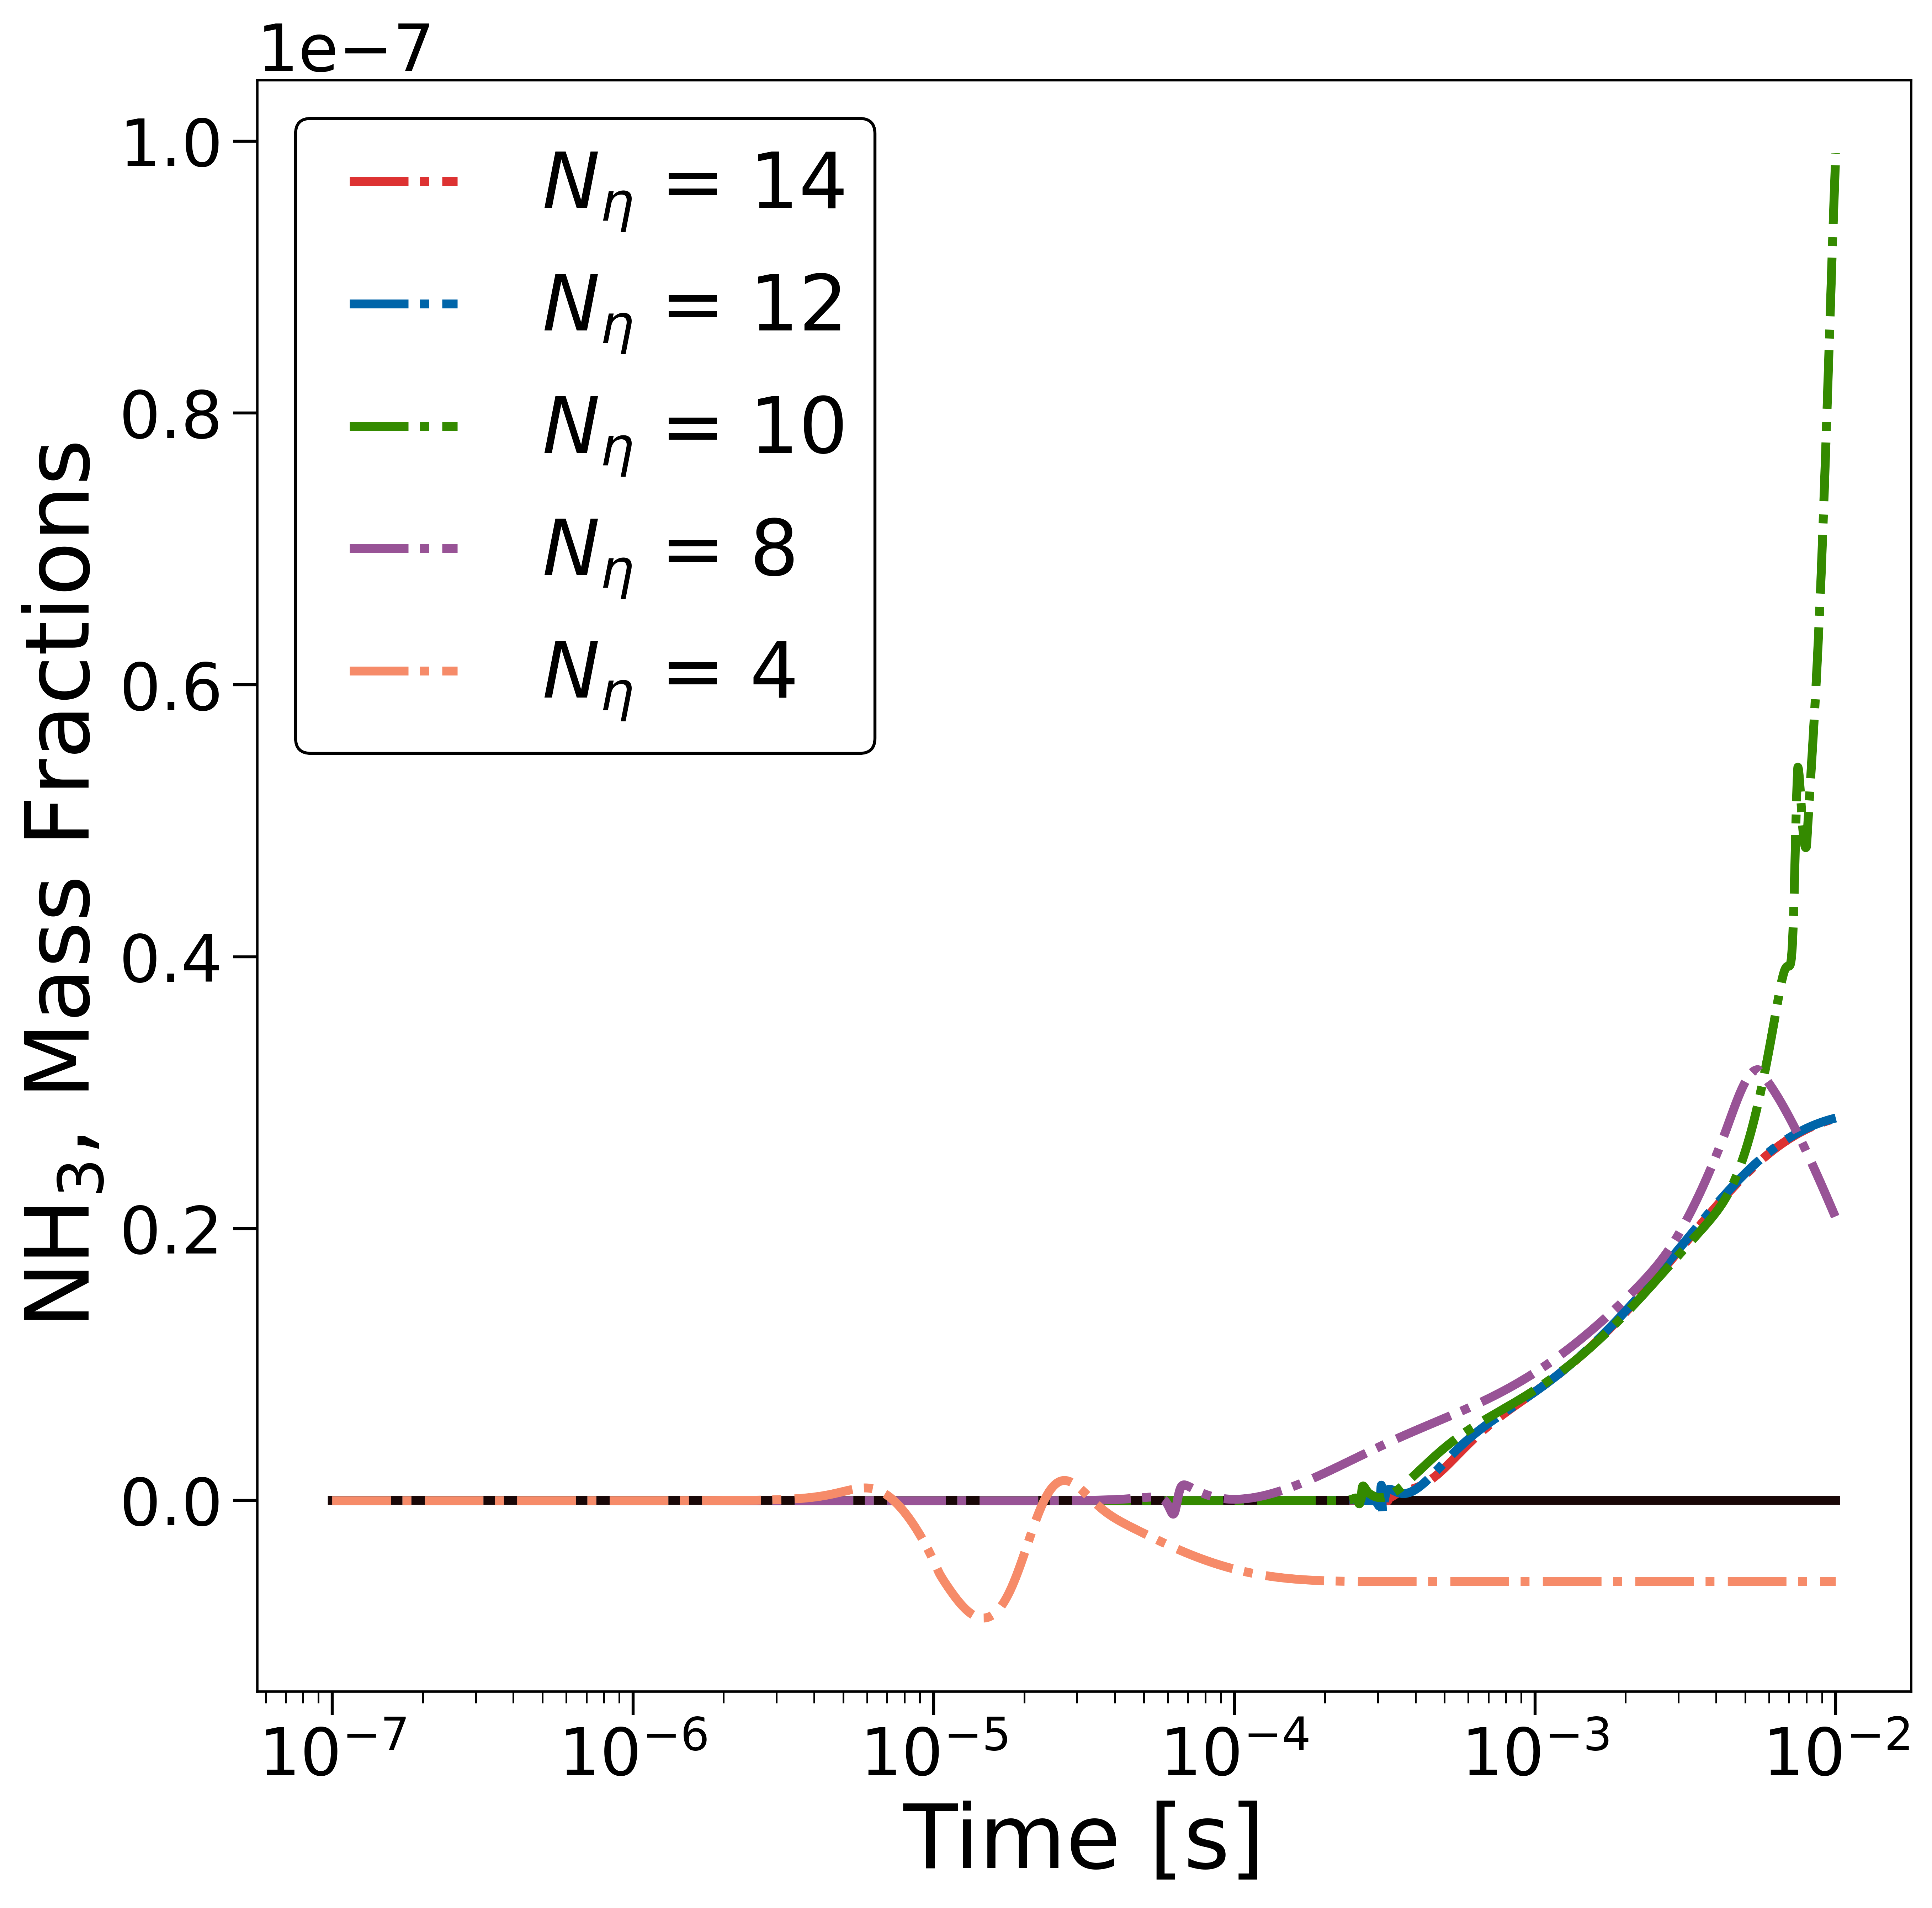

In [10]:
tVecFinal_Inv = [tVecFinal_]
Mat_Inv       = [Mat_]
nfev_vec      = [output.nfev]


PCVec         = [19,18,16,14,12,10,8,6,4,2]

plt.figure()
plt.plot(tVecFinal_Inv[0], Mat_Inv[0][:,iVar])


for iSim in range(1,len(PCVec)):
    NPC = PCVec[iSim]
    

    PCADir    = '/Users/sventur/WORKSPACE/ROMNet/Data/0DReact_Isobaric_10Cases_H2_Sources/'+str(NPC)+'PC/'


    FileName  = OutputDir+'/Orig/train/ext/CleanVars.csv'
    Species   = gas.species_names
    CleanVars = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()[0,:]

    FileName = PCADir+'/ROM/A.csv'
    A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()
    AT       = A.T

    FileName = PCADir+'/ROM/C.csv'
    C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy().T

    FileName = PCADir+'/ROM/D.csv'
    D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy().T

    to_orig = [0]
    for Var in CleanVars[1::]:
        to_orig.append(Species.index(Var)+1)

    n_species = gas.n_species

    InputVars = []
    for iVars in range(1,10):
        InputVars.append('PC_'+str(iVars))

    OutputVars = []
    for iVars in range(1,10):
        OutputVars.append('SPC_'+str(iVars))






    if (EqRatio0Exts is not None):
        P0       = ICs[iIC,0]
        EqRatio0 = ICs[iIC,1]
        T0       = ICs[iIC,2]
        print('Pressure = ', P0, 'Pa; EqRatio0 = ', EqRatio0, '; Temperature = ', T0, 'K')

    elif (X0Exts is not None) and (SpeciesVec is not None):
        P0       = ICs[iIC,0]
        T0       = ICs[iIC,1]
        print('Pressure = ', P0, 'Pa; Temperature = ', T0, 'K')


    ### Create Mixture
    gas     = ct.Solution(MixtureFile)

    Mask_ = []
    for Keep in KeepVec:
        Mask_.append(gas.species_names.index(Keep))
    Mask_ = np.array(Mask_)

    ### Create Reactor
    gas.TP  = T0, P0

    if (EqRatio0Exts is not None):
        gas.set_equivalence_ratio(EqRatio0, Fuel0, Oxydizer0)

    elif (X0Exts is not None) and (SpeciesVec is not None):
        SpecDict = {}
        for iS, Spec in enumerate(SpeciesVec):
            SpecDict[Spec] = ICs[iIC,iS+2]
        gas.X    = SpecDict
        print('   Mole Fractions = ', SpecDict)

    r       = ct.IdealGasConstPressureReactor(gas)
    sim     = ct.ReactorNet([r])
    sim.verbose = False

    gas_    = gas
    mass_   = r.mass
    # print('   Mass = ', mass_)
    density_= r.density
    P_      = P0
    y0      = np.array(np.hstack((gas_.T, gas_.Y)), dtype=np.float64)

    y0_PC        = ((y0[to_orig] - C)/D).dot(AT)
    y0_          = np.zeros(n_species+1)
    y0_[to_orig] = (y0_PC.dot(A))*D + C
    print('[PCA] Error = ', np.max(abs(y0 - y0_)))




    tVec             = np.logspace(np.log10(t0), np.log10(tEnd), NtInt)

    gas_             = gas
    states           = ct.SolutionArray(gas['H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2'], 1, extra={'t': [0.0]})

    output           = solve_ivp( IdealGasConstPressureReactor_PC_SciPY, (tVec[0],tVec[-1]), y0_PC[0,:], method=SOLVER, t_eval=tVec, rtol=rtol, atol=atol )
    it0              = 0
    tVecFinal_Inv.append(output.t)
    HRVec            = []
    it               = it0
    for t in tVecFinal_Inv[iSim][it:]:


        TT                   = output.y[0,it]
        YY                   = output.y[1:,it]

        Vec                  = np.concatenate(([TT],YY), axis=0)

        if (it == 0):
            Mat_PC     = np.array(Vec[np.newaxis,...])
        else:
            Mat_PC     = np.concatenate((Mat_PC, Vec[np.newaxis,...]),       axis=0)

        it+=1 


    Mat_Inv.append( (Mat_PC.dot(A))*D + C )


    if (NPC in [14,12,10,8,4]):
        plt.plot(tVecFinal_Inv[iSim], Mat_Inv[iSim][:,iVar], '-.', label=r'$N_{\eta}$ = '+str(NPC))

    nfev_vec.append(output.nfev)
    
plt.xlabel('Time [s]')
plt.ylabel(r''+VarOIName+', Mass Fractions')
plt.xscale('log')
# plt.xlim([1.e-6,1.e-3])
# plt.ylim([0.,0.05])
plt.legend()

plt.savefig(FigDir+'/0DReact_PCA_Integration_'+VarOI+'.eps', format='eps', bbox_inches='tight')

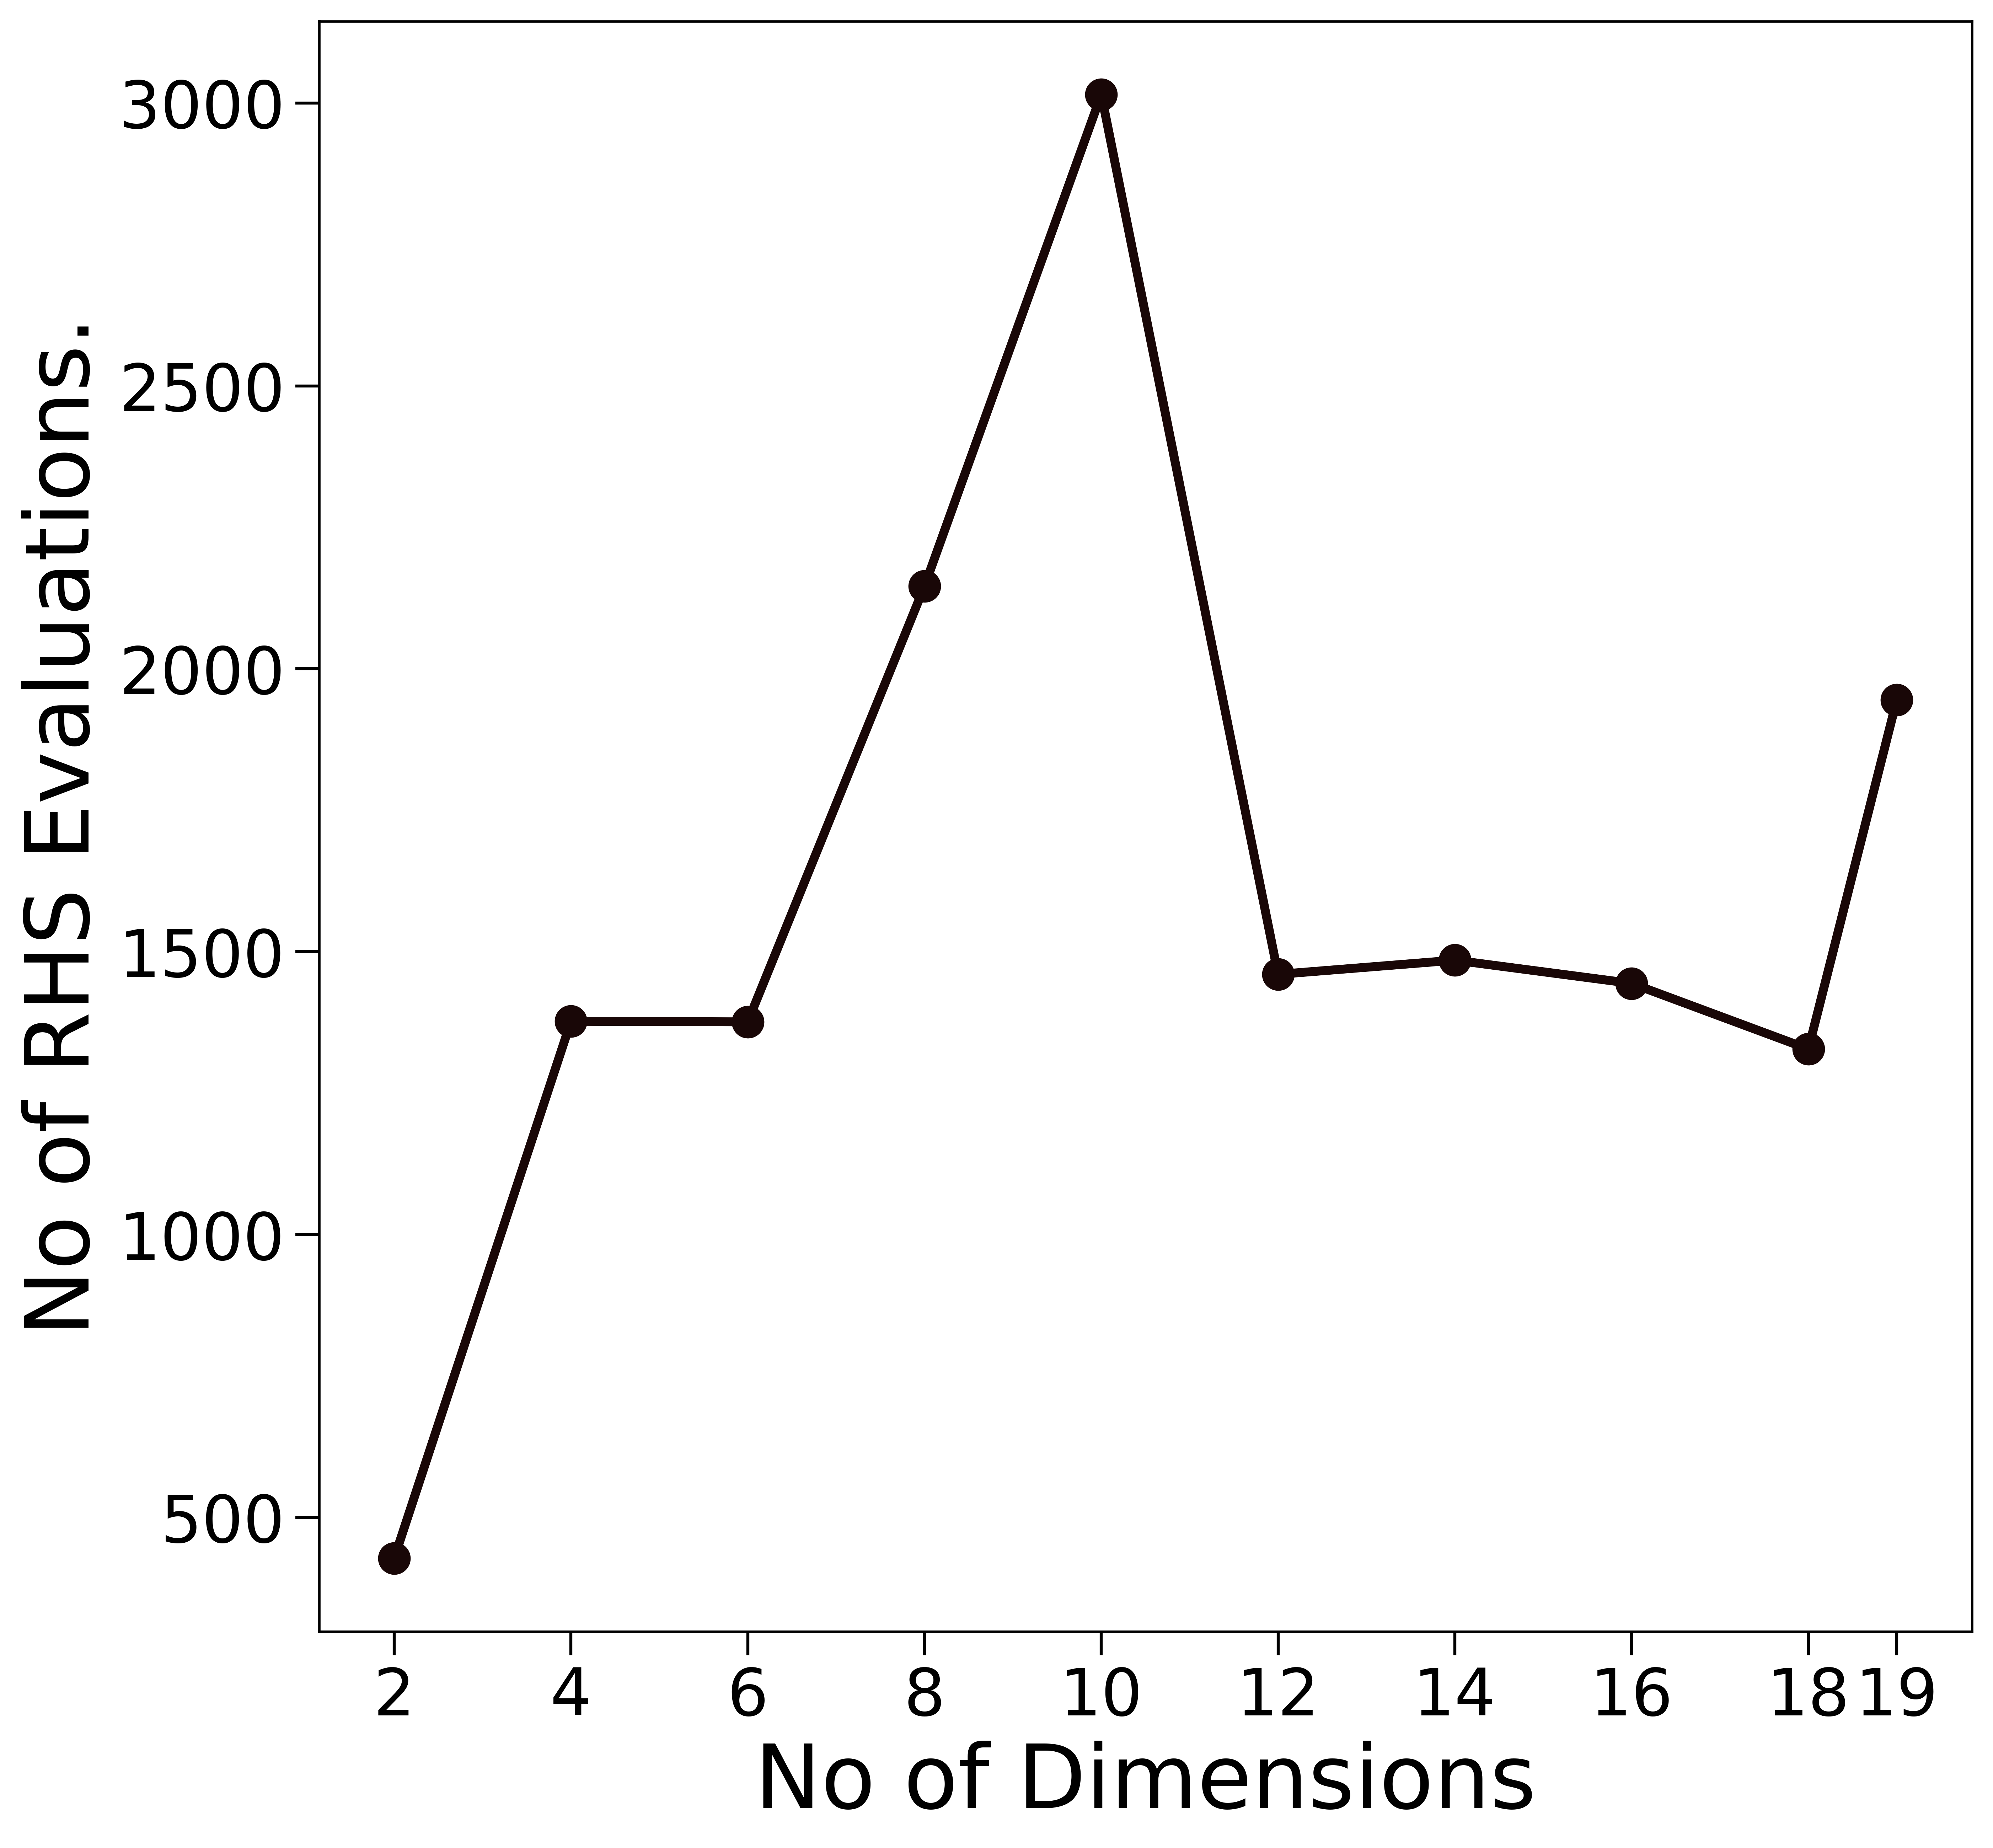

In [11]:
plt.plot(PCVec, nfev_vec, 'o-')
plt.xticks([2,4,6,8,10,12,14,16,18,19])

plt.xlabel('No of Dimensions')
plt.ylabel('No of RHS Evaluations.')
# plt.xscale('log')
# plt.xlim([1.e-6,1.e-2])
# plt.ylim([0.,0.05])
# plt.legend()

plt.savefig(FigDir+'/0DReact_PCA_NCalls.eps', format='eps', bbox_inches='tight')